### Getting the camera working

Here are some steps needed. First you need to enable the camera. In a terminal type `sudo raspi-config` and then use the arrow keys to select interface options and then enable the camera. A reboot is required.

Next we need to install the picamera Python modulg. In a terminal type the command

`sudo apt-get install python3-picamera`

Because the red led on the camera creates light inside the spectrometer, we can turn it off by adding this line in `/boot/config.txt` and rebooting

`disable_camera_led=1`

That's it.

In [2]:
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.image as img
import ipywidgets as widgets

from picamera import PiCamera
from PIL import Image
from time import sleep, strftime
from IPython.display import clear_output

### Some helper routines

In [40]:
def take_picture(shutter):
    print("Initialising camera")
    camera = PiCamera()
    stream = io.BytesIO()
    try:
        print("Allowing camera to warmup")
        #camera.resolution = (2592, 1944)
        camera.resolution = (1296, 972)        
        camera.framerate= 5
        camera.rotation = 270
        camera.iso = 800
        camera.shutter_speed = shutter
        camera.zoom = (0.50, 0.00, 0.15, 0.50)
        camera.awb_mode = 'off'
        camera.awb_gains = (1, 1)
        sleep(3)
        print("Capturing image")
        camera.capture(stream, format='jpeg')
        stream.seek(0)
        raw = Image.open(stream)
    finally:
        camera.close()
    return raw

In [28]:
def process_image(raw):

    pixels = np.asarray(raw)
    
    # Averaging along y
    pixels = np.average(pixels, axis=0)
    processed = Image.fromarray(np.uint8([pixels])) # The extra [] is to get back to image dimensions
    width, height = processed.size
    processed = processed.resize((width,255))
    
    return processed

In [56]:
def get_spectrum(processed):
    spectrum = np.asarray(processed)
    spectrum = np.average(spectrum[0], axis=1)
    spectrum = spectrum-(0.9*min(spectrum))  # Subtract baseline
    spectrum = spectrum*(200/max(spectrum))  # Normalize to 200
    
    return spectrum

In [57]:
def display_results(processed,spectrum,fname,shutter):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.rcParams.update({'font.size': 18})

    plt.xlabel('Pixel')
    plt.yticks([])
    plt.title('ORCSGirls Lego Spectrometer - Exposure: {}'.format(shutter))
    
    plt.imshow(processed, origin='lower', aspect=2)
    plt.plot(spectrum, color='yellow')

    plt.savefig(fname+'_processed.jpg')
    print("Plot saved to "+fname+"_processed.jpg")
    
    plt.show()

### Main control program

Initialising camera
Allowing camera to warmup
Capturing image
Plot saved to Spectra/Spectrum-20210927-172956_processed.jpg


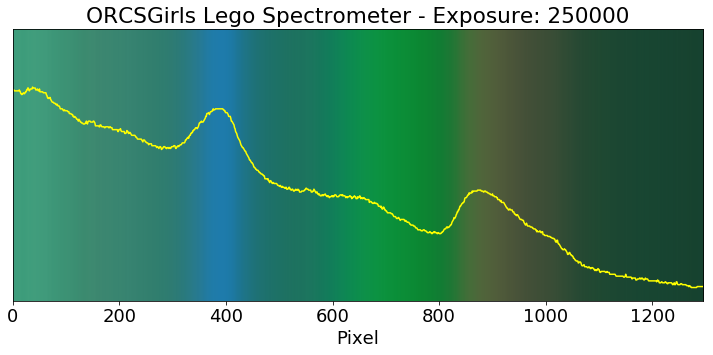

In [59]:
# Max exposure time (in usec)
shutter = 250000

timestr = strftime("%Y%m%d-%H%M%S")
fname = 'Spectra/Spectrum-'+timestr

raw = take_picture(shutter)
raw.save(fname+"_raw.jpg")

processed = process_image(raw)
spectrum = get_spectrum(processed)
display_results(processed, spectrum, fname, shutter)